# КУРСОВОЙ ПРОЕКТ

# "ПРЕДСКАЗАНИЕ ЦЕН НА НЕДВИЖИМОСТЬ"
### Слушатель факультета ИИ: Рудаков А.А.
Дата: февраль 2021

**Цель проекта:** Предсказать цену на недвижимость (квартиры) в датасете test.csv.  

**Источник данных:** Два (2)  датасета с сайта соревнований Kaggle: [Real Estate Price Predict](https://www.kaggle.com/c/real-estate-price-prediction-moscow)
- train.csv (содержит признаки и цены на квартиры)
- test.csv (содержит только признаки).

## ОГЛАВЛЕНИЕ

#### [Путь к директориям и файлам](#path)
#### [Загрузка базовых библиотек](#lib)
#### [Оптимизация памяти](#memory)

#### [1. Анализ файла train.csv](#1)
* **[Описание датасета train.csv](#data_desc)**
* **[Основные статистики по каждому признаку](#main_init)**
    * **[Анализ целевой переменной PRICE](#target_analytics)**
    * **[Анализ зависимости целевой переменной от исходных признаков](#target_feature_corr)**
    * **[Анализ признаков целевой переменной](#features_analytics)**
        * **[Количественные признаки](#num_features)**
        * **[Категориальные и бинарные признаки](#cat_bin_features)**
    * **[Заключение по анализу данных (до обработки)](#data_analysis_summary)**
   
#### [2. Анализ и обработа  данных исходного датасета EDA ](#EDA)
* **[Обработка исходного датасета](#initial_data_processing)**
* **[Разбиение исходного датасета](#train_split)**
* **[Подбор предварительной модели для исходного датасета](#intial_train_model)** 
  * **[Простая модель(Линейная регрессия)](#linear_initial)**
  * **[Сложная модель(Kинейная регрессия с L1-регуляризацией)](#dRegularity_initial)**
  
  

**Путь к директориям и файлам**<a class='anchor' id='path'>

In [243]:
DATASET_PATH = './train.csv'
PREPARED_DATASET_PATH = './prepeared_train.csv'

REPORTS_FILE_PATH = './reports/'
SCALER_FILE_PATH = './models/scaler.pkl'
MODEL_FILE_PATH = './models/model.pkl'

**Загрузка базовых библиотек** <a class ='anchor' id = 'lib'> 

In [364]:
import numpy as np
import pandas as pd
import pickle # сохранение модели

from matplotlib import pyplot as plt
from pylab import rcParams as rc
import seaborn as sns
from IPython.display import Image #Для визуализации внешних картинок в ноутбуке

from scipy.stats import mode,skew
from statistics import variance, median

# Загрузка моделей (библиотек) для обучения sci-kit learn (sklearn)

from sklearn.model_selection import train_test_split, KFold, GridSearchCV # Разделение датасета
from sklearn.linear_model import LinearRegression, Lasso, Ridge

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVC

#Активация отображения графиков matlib/mathlab 

%matplotlib inline 

# Для четкости отображения графиков и текста

%config InlineBackend.figure_format = 'svg'

**Оптимизация памяти под данные** <a class ='anchor' id ='memory'>

In [245]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

### 1. Анализ файла train.csv<a class='anchor' id='1'>

**Описание датасета**<a class = 'anchor' id = 'data_desc'>
    
* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

**Основные статистики по каждому признаку** <a class='anchor' id='main_init'>  
    
- Расчет основных статистик (минимальные, максимальные, средние значения и т.д) по признакам и по целевой переменной.
- Выводы об адекватности основных статистик.
- Подсчет для каждого признака, сколько в нем уникальных значений и как часто они встречаются.
- Выводы по каждому признаку.

In [246]:
df = pd.read_csv(DATASET_PATH, sep =',')
df_train = reduce_mem_usage(df)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


In [247]:
keys = df_train.keys()
keys_lst = [keys[i] for i in range(len(keys))]
print('Список названий колонок (ключи) train.csv :\n {}\n\nКоличество ключей(колонок): {}'.format(keys_lst, len(keys_lst)))

Список названий колонок (ключи) train.csv :
 ['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2', 'Price']

Количество ключей(колонок): 20


In [248]:
df_train.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.0000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315720,37.199665,6.273300,8.526700,12.6094,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214138.937500
std,4859.01902,43.587592,0.839522,21.058716,86.241219,28.560839,5.241148,6.7762,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.519470,1.493601,4.806341,92872.273438
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.0000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,4169.50000,20.000000,1.000000,41.774879,22.769833,1.000000,4.000000,9.0000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,8394.50000,36.000000,2.000000,52.513309,32.781261,6.000000,7.000000,13.0000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,12592.50000,75.000000,2.000000,65.900627,45.128803,9.000000,12.000000,17.0000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,16798.00000,209.000000,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.0000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


In [249]:
df_train[keys_lst].median()

Id                 8394.500000
DistrictId           36.000000
Rooms                 2.000000
Square               52.513309
LifeSquare           32.781261
KitchenSquare         6.000000
Floor                 7.000000
HouseFloor           13.000000
HouseYear          1977.000000
Ecology_1             0.075424
Social_1             25.000000
Social_2           5285.000000
Social_3              2.000000
Healthcare_1        900.000000
Helthcare_2           1.000000
Shops_1               3.000000
Price            192269.656250
dtype: float64

In [250]:
df_train[keys_lst].nunique()

Id               10000
DistrictId         205
Rooms                9
Square            9995
LifeSquare        7886
KitchenSquare       58
Floor               33
HouseFloor          44
HouseYear           97
Ecology_1          129
Ecology_2            2
Ecology_3            2
Social_1            51
Social_2           142
Social_3            30
Healthcare_1        79
Helthcare_2          7
Shops_1             16
Shops_2              2
Price             9996
dtype: int64

In [251]:
for i in range(len(keys_lst)):
    print('[{}] * {} '.format(df_train[keys_lst[i]].name, df_train[keys_lst[i]].mode()[0]))

[Id] * 0 
[DistrictId] * 27 
[Rooms] * 2.0 
[Square] * 37.49816131591797 
[LifeSquare] * 33.85965347290039 
[KitchenSquare] * 1.0 
[Floor] * 4 
[HouseFloor] * 17.0 
[HouseYear] * 1977 
[Ecology_1] * 0.007122316863387823 
[Ecology_2] * B 
[Ecology_3] * B 
[Social_1] * 2 
[Social_2] * 264 
[Social_3] * 0 
[Healthcare_1] * 540.0 
[Helthcare_2] * 0 
[Shops_1] * 0 
[Shops_2] * B 
[Price] * 182938.078125 


In [252]:
target = df['Price'] # Целевая переменная для которой нужен прогноз

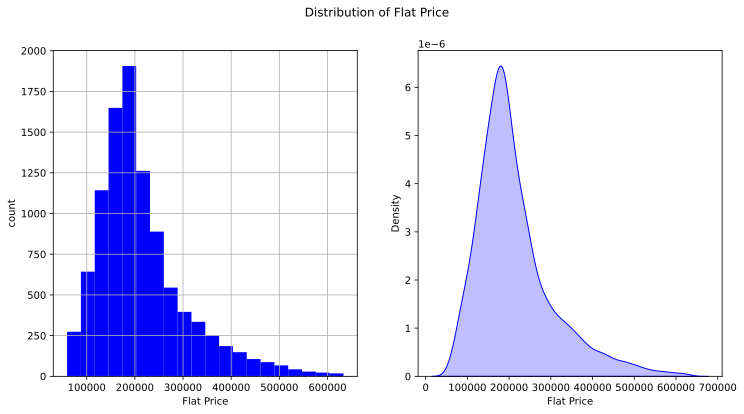

In [253]:
plt.figure(figsize = (12, 6))

plt.subplot(121)
target.hist(density=False,color = '#0000FF', bins=20)
plt.ylabel('count')
plt.xlabel('Flat Price')

plt.subplot(1,2,2)
sns.kdeplot(target, color = '#0000FF', shade=True, legend=False)
plt.xlabel('Flat Price')

plt.suptitle('Distribution of Flat Price')
plt.show()

In [254]:
print("Skewness: %f" % target.skew())
print("Kurtosis: %f" % target.kurt())
print("Variance: %f" % variance(target))
print("Mode: %f" % mode(target)[0])
print("Median: %f" % median(target))

Skewness: 1.366877
Kurtosis: 2.249410
Variance: 8625262983.915672
Mode: 182938.078125
Median: 192269.648438


Распределние целевой переменной отклоняется от нормального, положительно ассиметрично, выборка смещена влево:
- коэфциентом асссиметрии больше 0 (1.36667)
- эксцесс 2.24 (распределение отклонено от нормального)
- mode = 182 938.9156
- mediana = 192 269.648438
- variance = 8 62262 983 (достаточно высокая дисперсия, следует проверить данные)

In [255]:
target_mean =target.mean()
target_moda = mode(target)[0]
target_mediana = median(target)

In [256]:
print("Mean: %f" % target_mean)
print("Mode: %f" % target_moda)
print("Median: %f" % target_mediana)

Mean: 214138.937500
Mode: 182938.078125
Median: 192269.648438


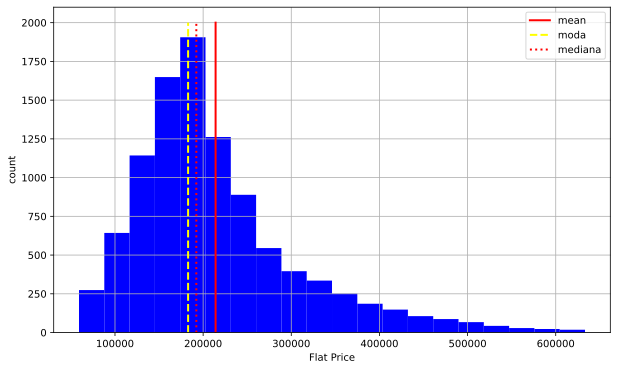

In [257]:
plt.figure(figsize = (10, 6))

y = np.linspace(0, 2000, 500) # Дял генерации вертикальной черты значений среднего,медианы и моды

target.hist(density = False, color = '#0000FF', bins=20)
plt.ylabel('count')
plt.xlabel('Flat Price')

plt.plot([target_mean]*500, y, color ='red', label='mean', linestyle='-', linewidth=2)
plt.plot([target_moda]*500, y, color ='yellow', label='moda', linestyle='--', linewidth=2)
plt.plot([target_mediana]*500, y, color ='red', label='mediana', linestyle=':', linewidth=2)

plt.legend()
plt.show()

In [258]:
print("50pr %f" % np.quantile(target, q=0.5))
print("25pr %f" % np.quantile(target, q=0.25))

50pr 192269.648438
25pr 153872.628906


In [259]:
np.quantile(target, q=0.25)

153872.62890625

Самая часто встречающаяся цена на квартиру в генеральной совокупности ниже среднего значения и приближается к медианному значению целефой переменной.

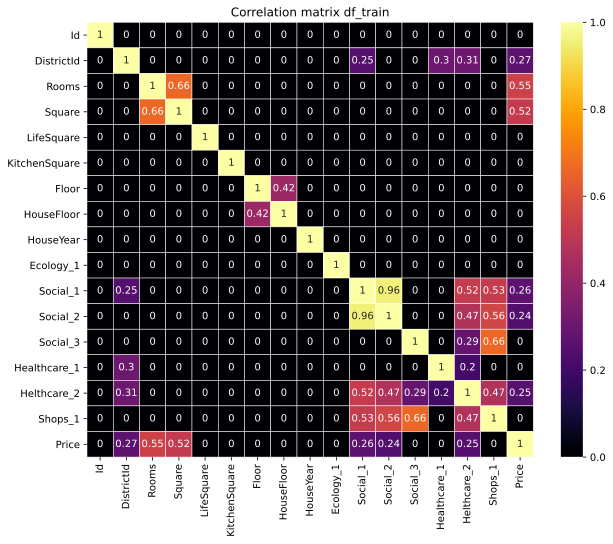

In [260]:
df_train_cor = df_train.corr()

plt.figure(figsize = (10,8))

np.round(df_train_cor, 2) # Округляем значение корреляции до 2 знаков после запятой

df_train_cor[np.abs(df_train_cor)<0.2] = 0 # Упрощаем отображение данных, по корреляции,оставив наиболеее полезные значения

sns.heatmap(df_train_cor, annot=True, linewidths=.5, cmap='inferno')

plt.title('Correlation matrix df_train')
plt.show()

Оценка корреляции целевой переменной Price показывает, что с ней наиболее тесно взаимосвязаны такие признаки, как:
- **Rooms** (кол-во комнат) ***0,55***
- **Square** (площадь квартиры) ***0.52***

In [261]:
df_train_cor['Price'] #Корреляции признаков с целевой переменной

Id               0.000000
DistrictId       0.265100
Rooms            0.550291
Square           0.520075
LifeSquare       0.000000
KitchenSquare    0.000000
Floor            0.000000
HouseFloor       0.000000
HouseYear        0.000000
Ecology_1        0.000000
Social_1         0.263286
Social_2         0.239226
Social_3         0.000000
Healthcare_1     0.000000
Helthcare_2      0.253090
Shops_1          0.000000
Price            1.000000
Name: Price, dtype: float64

Наибольшаяя кореляциия наблюдается у признаков  **Rooms** (кол-во комнат) ***0,55***, **Square** (площадь квартиры) ***0.52***

Наименьшая кореляциия наблюдается у признаков  **DistricId**(район расположения квартиры) ***0.27*** и социальными уровнями местности (**Social_1, Social_2**) со значениями ***0.26*** и ***0.24***, а так же с показателями уровня здравоохранения **Healthcare_2** со значениями ***0.25***. 

Все остальные признаки малозначимы и дают значение показателя  кореляции менее 0.2.

**Анализ зависимости целевой перемнной от исходных признаков** <a class='anchor' id='target_feature_corr'>  

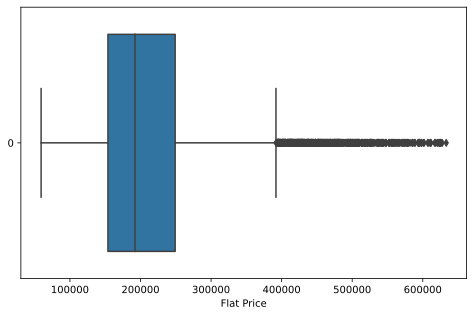

In [262]:
plt.figure(figsize=(8, 5))
sns.boxplot(data = target, orient ='h')
plt.xlabel('Flat Price')
plt.show()

Целеваая переменная имеет выбросы,которые необходимо обработать.

**Анализ признаков(features) целевой переменной** <a class ='anchor' id ='features_analytics'>

In [263]:
df_target_features_name = df_train.columns.drop(target.name) # имена исходных признаков (features name ) для целевой переменной

In [264]:
df_target_features = df_train.drop([target.name, 'Id'], axis = 1) # значения исходных признаков (features) для целевой переменной
df_target_features

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,27,3.0,115.027313,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B
1,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B
2,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B
3,1,1.0,40.409908,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B
4,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,61,2.0,49.090729,33.272625,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B
9996,27,2.0,64.307686,37.038422,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A
9997,178,1.0,29.648056,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B
9998,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B


In [265]:
df_target_features.isna().sum()

DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
dtype: int64

В признаках ***LifeSquare*** и ***Healthcare_1*** пропущены значения в кол-ве 2112 и 4798  соответственно.     

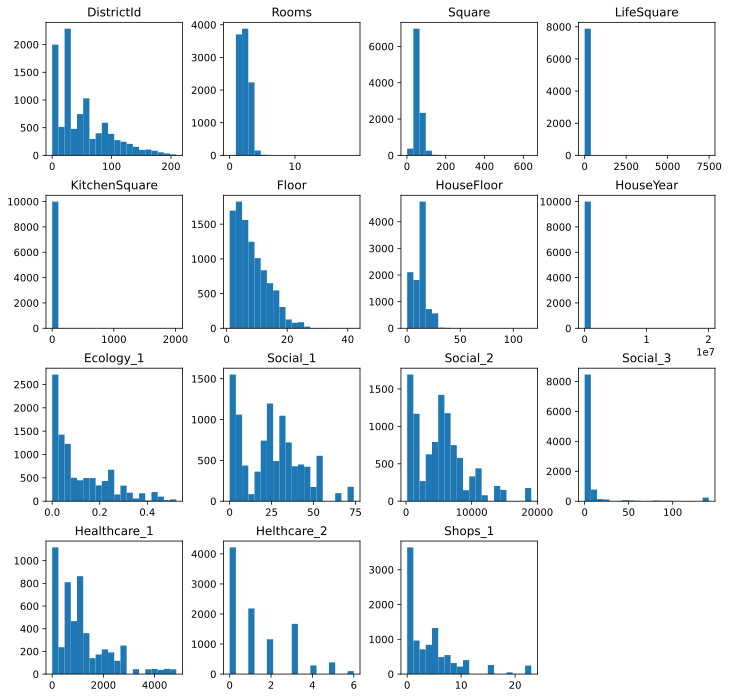

In [266]:
df_target_features.hist(figsize=(12,12), bins=20, grid=False)

plt.show()

<AxesSubplot:>

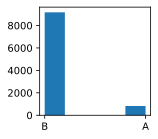

In [267]:
df_train['Shops_2'].hist(figsize=(2,2), bins=5, grid=False)

***Количественные признаки*** <a class ='anchor' id = 'num_features'>

In [268]:
df_target_features_num = df_train.select_dtypes(include=['float64', 'float32', 'float16']) # Кол-ные переменные
df_target_features_num.drop(target.name, axis = 1, inplace = True) 
df_target_features_num


C:\Users\aruda\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,Rooms,Square,LifeSquare,KitchenSquare,HouseFloor,Ecology_1,Healthcare_1
0,3.0,115.027313,NaN,10.0,10.0,0.075424,NaN
1,1.0,39.832523,23.169222,8.0,8.0,0.118537,1183.0
2,3.0,78.342216,47.671970,10.0,17.0,0.025609,240.0
3,1.0,40.409908,NaN,1.0,22.0,0.007122,NaN
4,2.0,64.285065,38.562515,9.0,16.0,0.282798,NaN
...,...,...,...,...,...,...,...
9995,2.0,49.090729,33.272625,6.0,12.0,0.300323,NaN
9996,2.0,64.307686,37.038422,9.0,0.0,0.072158,NaN
9997,1.0,29.648056,16.555363,5.0,5.0,0.460556,NaN
9998,1.0,32.330292,22.326870,5.0,9.0,0.194489,125.0


In [269]:
print("Кол-во признаков целевой перемнной: %f" % len(df_target_features_name))
print("Кол-во КОЛИЧЕСТВЕННЫХ признаков целевой перемнной: %f" % len(df_target_features_num.columns))

Кол-во признаков целевой перемнной: 19.000000
Кол-во КОЛИЧЕСТВЕННЫХ признаков целевой перемнной: 7.000000


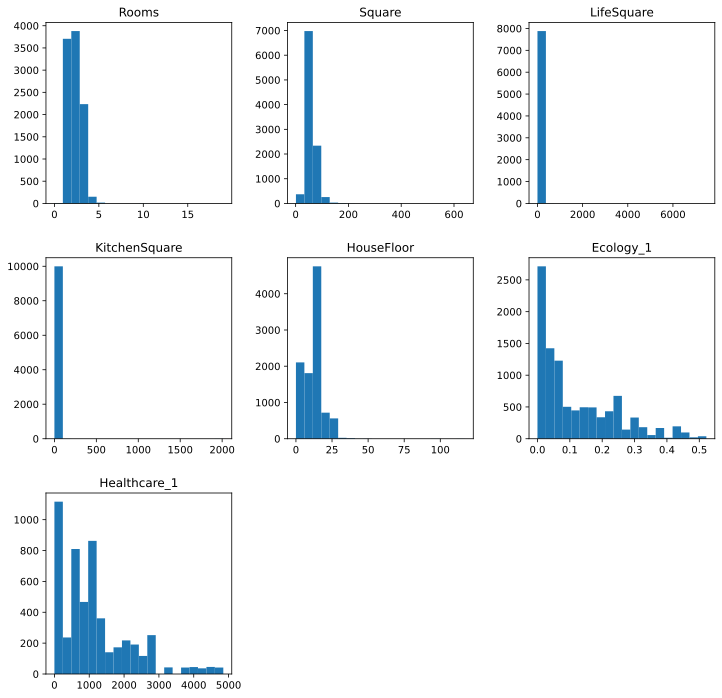

In [270]:
df_target_features_num.hist(figsize=(12,12), bins=20, grid=False)

plt.show()

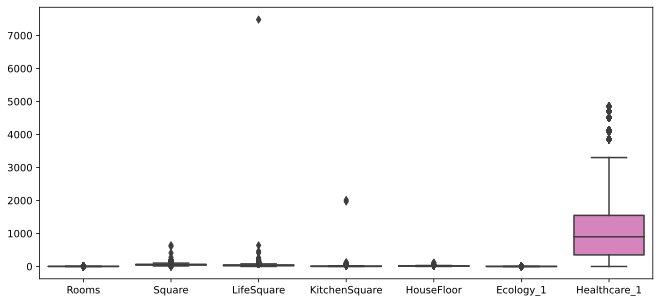

In [271]:
plt.figure(figsize=(11, 5))

sns.boxplot(data = df_target_features_num, whis=1.5)

plt.show()

Выбросы наблюдаются для признаков : ***Square, LifeSquare, KitchenSquare, Healthcare_1***

***Категориальные и бинарные признаки*** <a class ='anchor' id = 'cat_bin_features'>

In [272]:
df_target_features.drop(list(df_target_features_num.columns), axis =1 )
print(df_target_features.info())
df_target_features_cat = df_target_features.select_dtypes(include='category')
df_target_features_cat

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   DistrictId     10000 non-null  int16   
 1   Rooms          10000 non-null  float32 
 2   Square         10000 non-null  float32 
 3   LifeSquare     7887 non-null   float32 
 4   KitchenSquare  10000 non-null  float32 
 5   Floor          10000 non-null  int8    
 6   HouseFloor     10000 non-null  float32 
 7   HouseYear      10000 non-null  int32   
 8   Ecology_1      10000 non-null  float32 
 9   Ecology_2      10000 non-null  category
 10  Ecology_3      10000 non-null  category
 11  Social_1       10000 non-null  int8    
 12  Social_2       10000 non-null  int16   
 13  Social_3       10000 non-null  int16   
 14  Healthcare_1   5202 non-null   float32 
 15  Helthcare_2    10000 non-null  int8    
 16  Shops_1        10000 non-null  int8    
 17  Shops_2        10000 non-null  c

,Ecology_2,Ecology_3,Shops_2
0,B,B,B
1,B,B,B
2,B,B,B
3,B,B,B
4,B,B,B
...,...,...,...
9995,B,B,B
9996,B,B,A
9997,B,B,B
9998,B,B,B


In [273]:
df_target_features_cat['Ecology_2'].unique()

['B', 'A']
Categories (2, object): ['B', 'A']

In [274]:
df_target_features_cat['Ecology_3'].unique()

['B', 'A']
Categories (2, object): ['B', 'A']

In [275]:
df_target_features_cat['Shops_2'].unique()

['B', 'A']
Categories (2, object): ['B', 'A']

Категориальные признаки ***Ecology_2, Ecology_3, Shops_2*** можно привести к бинарным.

In [276]:
df_target_features_bin = df_train.select_dtypes(include=['int64','int32','int16', 'int8'])

In [277]:
df_target_features_bin

,Id,DistrictId,Floor,HouseYear,Social_1,Social_2,Social_3,Helthcare_2,Shops_1
0,11809,27,4,2014,11,3097,0,0,0
1,3013,22,7,1966,30,6207,1,1,0
2,8215,1,2,1988,33,5261,0,3,1
3,2352,1,10,1977,1,264,0,0,1
4,13866,94,16,1972,33,8667,2,0,6
...,...,...,...,...,...,...,...,...,...
9995,1260,61,3,1981,52,10311,6,1,9
9996,16265,27,13,1977,2,629,1,0,0
9997,2795,178,3,1958,20,4386,14,1,5
9998,14561,21,3,1969,47,8004,3,3,5


In [278]:
df_target_features_bin.describe()

,Id,DistrictId,Floor,HouseYear,Social_1,Social_2,Social_3,Helthcare_2,Shops_1
count,10000.00000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,8.526700,3.990166e+03,24.687000,5352.157400,8.039200,1.319500,4.231300
std,4859.01902,43.587592,5.241148,2.005003e+05,17.532614,4006.799803,23.831875,1.493601,4.806341
min,0.00000,0.000000,1.000000,1.910000e+03,0.000000,168.000000,0.000000,0.000000,0.000000
25%,4169.50000,20.000000,4.000000,1.974000e+03,6.000000,1564.000000,0.000000,0.000000,1.000000
50%,8394.50000,36.000000,7.000000,1.977000e+03,25.000000,5285.000000,2.000000,1.000000,3.000000
75%,12592.50000,75.000000,12.000000,2.001000e+03,36.000000,7227.000000,5.000000,2.000000,6.000000
max,16798.00000,209.000000,42.000000,2.005201e+07,74.000000,19083.000000,141.000000,6.000000,23.000000


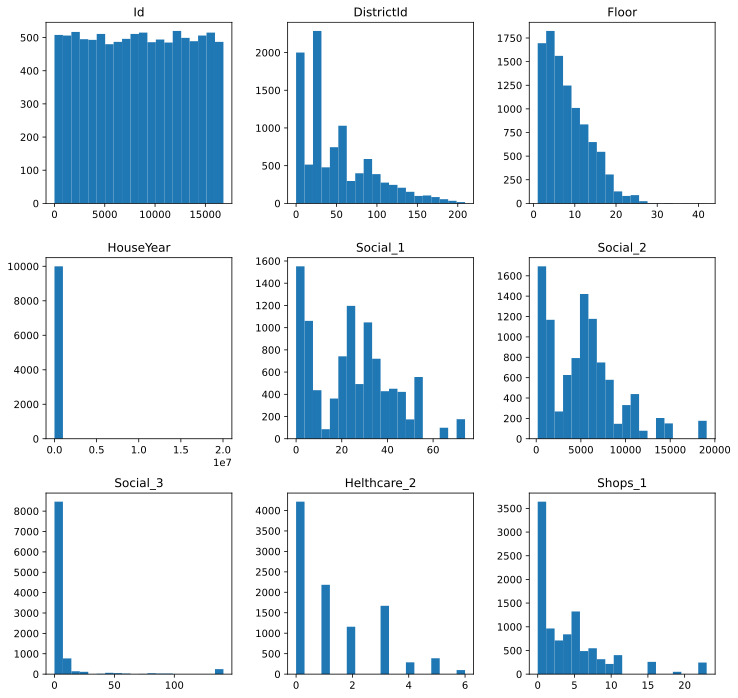

In [279]:
df_target_features_bin.hist(figsize=(12,12), bins=20, grid=False)

plt.show()

In [280]:
df_target_features_bin['Helthcare_2'].unique()

array([0, 1, 3, 2, 5, 4, 6], dtype=int8)

In [281]:
df_target_features_bin['Helthcare_2'].nunique()

7

In [282]:
df_target_features_bin['Helthcare_2'].value_counts()

0    4214
1    2183
3    1670
2    1158
5     388
4     288
6      99
Name: Helthcare_2, dtype: int64

Признак ***Helthcare_2*** отнесем к категориальным со шкалой от 0 до 6.

**Выводы об основных статистиках для признаков**:


* **Rooms** - минимальное значение 0 (некорректные наблюдения)
* **Square** - минимальная площадь квартиры 1м2 (некорректные наблюдения)
* **LifeSquare** - максимальное значение жилой площади завышено 7480 м2 (некорректные наблюдения)
* **KitchenSquare** - максимальное значение площади кухни завышено 2014 м2 (некорректные наблюдения)
* **HouseFloor** - максимальное значение этажа дома 117 (некорректные наблюдения)
* **HouseYear** - данные необходимо проверить и отформатировать

* **LifeSquare,HouseYear** - имеют пропущенные данные
* **LifeSquare (std=86), Social_2 (std=4006), Healthcare_1 (std=1021)** -наблюдается очень высокое отклонение значений от среднего по выборке, существуют выбросы.

In [283]:
print('Max HouseYear: {}'.format(df_train.sort_values(by= ['HouseYear'],ascending=True)['HouseYear'].max()))
print('Min HouseYear: {}'.format(df_train.sort_values(by= ['HouseYear'],ascending=True)['HouseYear'].min()))
print('Median: {}'.format(df_train.sort_values(by= ['HouseYear'],ascending=True)['HouseYear'].median()))
print('variance HouseYear: {}'.format(df_train.sort_values(by= ['HouseYear'],ascending=True)['HouseYear'].var()))

Max HouseYear: 20052011
Min HouseYear: 1910
Median: 1977.0
variance HouseYear: 40200354832.38829


Значения признака **HouseYear** заполнены не корректно,т.к. максимальное значение 200520211, что похоже на два года 2005 и 2011, при минимально знаечнии 1971.

In [284]:
df_train.sort_values(by= ['Rooms'],ascending=True)['Rooms'].unique()

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6., 10., 19.], dtype=float32)

In [285]:
df_train.sort_values(by= ['HouseFloor'],ascending=True)['HouseFloor'].unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.],
      dtype=float32)

In [286]:
df_train.sort_values(by= ['Floor'],ascending=True)['Floor'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int8)

Дополнительные данные по уникальным значениям:
* Кол-во комнат имеет выброс равные 0 и 19,а так же под вопросом 10. Остальные значения 1-6 вполне логичные.
* Кол-во этажей дома так же имеет выбросы в виде значений равных 0, 99 и 117. Это доказывает и тот факт, что номер этажа квартиры находится в диапазоне от 1-42.

***Этажность дома и кол-во квартир можно использовать для генерации новых признаков позже.***

In [287]:
title_font = {
    'fontsize': 16,
    'fontweight': 10,
    'color': '#191970',
    'family':'Times New Roman'}

label_font = {
    'fontsize': 12,
    'fontweight': 8,
    'color': '#191970',
    'family':'Times New Roman'}

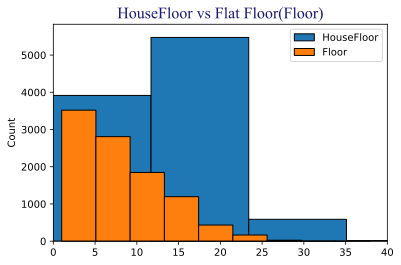

In [288]:
plt.figure(figsize=(6, 4))

plt.hist(df_train.sort_values(by= ['HouseFloor'],ascending=True)['HouseFloor'], label ='HouseFloor',ec ='black')
plt.ylabel('Count')
plt.title('HouseFloor vs Flat Floor(Floor)', fontdict = title_font)

plt.axis([0,40,0,df_train['HouseFloor'].value_counts().max()*2.5])

plt.hist(df_train.sort_values(by= ['Floor'],ascending=True)['Floor'], label ='Floor', ec ='black')

plt.legend()


(array([2514., 2765., 1775.,  696.,  976.,  520.,  360.,  204.,  139.,
          51.]),
 array([  0. ,  20.9,  41.8,  62.7,  83.6, 104.5, 125.4, 146.3, 167.2,
        188.1, 209. ]),
 <BarContainer object of 10 artists>)

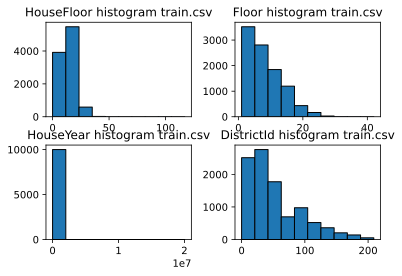

In [289]:
fig,ax = plt.subplots(nrows = 2, ncols = 2)

fig.subplots_adjust(hspace = 0.3, wspace = 0.3) # Вертикальные зазоры графика в дюймах
rc['figure.figsize'] = (8,6) #Установка размера фигуры 8' x 6'

ax1,ax2,ax3,ax4 = ax.flatten() # Преобразование в одномерный массив,чтобы не брать кортежи

x1 = df_train.sort_values(by= ['HouseFloor'],ascending=True)['HouseFloor']
x2 = df_train.sort_values(by= ['Floor'],ascending=True)['Floor']
x3 = df_train.sort_values(by= ['HouseYear'],ascending=True)['HouseYear']                       
x4 = df_train.sort_values(by= ['DistrictId'],ascending=True)['DistrictId'] 

y = df_train.sort_values(by= ['Price'],ascending=True)
                               
ax1.hist(x1,ec ='black')


ax1.set_title('HouseFloor histogram train.csv')
ax2.set_title('Floor histogram train.csv')
ax3.set_title('HouseYear histogram train.csv')
ax4.set_title('DistrictId histogram train.csv')

ax2.hist(x2,ec ='black')
ax3.hist(x3,ec ='black')
ax4.hist(x4,ec ='black')

In [290]:
print(df_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  int16   
 1   DistrictId     10000 non-null  int16   
 2   Rooms          10000 non-null  float32 
 3   Square         10000 non-null  float32 
 4   LifeSquare     7887 non-null   float32 
 5   KitchenSquare  10000 non-null  float32 
 6   Floor          10000 non-null  int8    
 7   HouseFloor     10000 non-null  float32 
 8   HouseYear      10000 non-null  int32   
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  int8    
 13  Social_2       10000 non-null  int16   
 14  Social_3       10000 non-null  int16   
 15  Healthcare_1   5202 non-null   float32 
 16  Helthcare_2    10000 non-null  int8    
 17  Shops_1        10000 non-null  i

#### Заключение по анализу данных (до обработки) <a class ='anchor' id = 'data_analysis_summary'>

***Количественные признаки:*** 
- аа ( 1229)
- ооо (56)

***Категориальные признаки:*** 
- аа ( 1229)
- ооо (56)

***Бинарные признаки:*** 
- аа ( 1229)
- ооо (56)

***Наиболее коррелирующие призаки с целевой переменной***
- ввв( cor:)


***Признаки с пустыми значениями(isna)***
- LifeSquare (2113 na)
- Helthcare_1 (4798 na)

***Признаки с наличием выборосов***
- ввв( cor:)



### Анализ и обработка данных (EDA) <a class='anchor' id='EDA'>

- Используя выводы выше обработать где есть пропуски, выбросы или неадекватные значения, используя фильтрацию из pandas, чтобы  оставить только самые "правильные" данные.
- Разбейте датасет из train.csv на обучающий и валидационный наборы данных.
- Заполните пропущенные значения в датасете медианами или модами.
- Переведите строковый признак в числовое представление.

In [291]:
df_train.isna().sum() # Проверка на пропуски данных 0 - нет, 1 - есть, и подсчет кол-во пропусков по признаку

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [292]:
df_train1 = df_train.copy() # Создадим копию исходного датасета

**Обработка исходного датасета** <a class = 'anchor' id = 'initial_data_processing'>

In [293]:
# Заполняем пропуски медианными значениями

median_ls = df_train1['LifeSquare'].median()
median_hc1 = df_train1['Healthcare_1'].median()

df_train1['LifeSquare'] = df_train1['LifeSquare'].fillna(median_ls)
df_train1['Healthcare_1'] = df_train1['Healthcare_1'].fillna(median_hc1)

df_train1.isna().sum()

Id               0
DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Shops_2          0
Price            0
dtype: int64

In [294]:
# Замена строковых A и B на числовые данные A = 1,  B = 0

df_train1['Ecology_2'] = (df_train1['Ecology_2'] =='B').astype(int)
df_train1['Ecology_3'] = (df_train1['Ecology_2'] =='B').astype(int)
df_train1['Shops_2'] = (df_train1['Ecology_2'] =='B').astype(int)

df_train1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int16  
 1   DistrictId     10000 non-null  int16  
 2   Rooms          10000 non-null  float32
 3   Square         10000 non-null  float32
 4   LifeSquare     10000 non-null  float32
 5   KitchenSquare  10000 non-null  float32
 6   Floor          10000 non-null  int8   
 7   HouseFloor     10000 non-null  float32
 8   HouseYear      10000 non-null  int32  
 9   Ecology_1      10000 non-null  float32
 10  Ecology_2      10000 non-null  int32  
 11  Ecology_3      10000 non-null  int32  
 12  Social_1       10000 non-null  int8   
 13  Social_2       10000 non-null  int16  
 14  Social_3       10000 non-null  int16  
 15  Healthcare_1   10000 non-null  float32
 16  Helthcare_2    10000 non-null  int8   
 17  Shops_1        10000 non-null  int8   
 18  Shops_2

**Разбиение датасета** <a class ='anchor' id ='train_split'>
Создание обучающего и валидационного дата сетов из копии датасет train с отредактированными данными

In [295]:
X = df_train1.drop(['Price'], axis =1)
Y = df_train1['Price']
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.5, random_state=42)

In [296]:
print('X_train shape: {}\nX_train size: {}'.format(X_train.shape,X_train.size))
print('X_valid shape: {}\nX_train size: {}'.format(X_train.shape,X_valid.size))
print('y_train shape: {}\nX_train size: {}'.format(X_train.shape,y_train.size))
print('y_valid shape: {}\nX_train size: {}'.format(X_train.shape,y_valid.size))

X_train shape: (5000, 19)
X_train size: 95000
X_valid shape: (5000, 19)
X_train size: 95000
y_train shape: (5000, 19)
X_train size: 5000
y_valid shape: (5000, 19)
X_train size: 5000


In [297]:
X_train.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5.000000e+03,5000.000000,5000.000000,5000.0,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.0
mean,8342.675200,50.172400,1.893200,56.389702,35.286102,6.221600,8.485200,12.533600,5.995540e+03,0.117473,0.989400,0.0,24.436800,5303.014200,7.839200,1015.544189,1.302400,4.151200,0.0
std,4891.461288,43.725899,0.810152,22.840694,18.854881,28.232946,5.202422,6.728992,2.835502e+05,0.118304,0.102419,0.0,17.601238,4030.196974,23.566952,748.033142,1.479795,4.755593,0.0
min,11.000000,0.000000,0.000000,1.136859,0.641822,0.000000,1.000000,0.000000,1.912000e+03,0.000000,0.000000,0.0,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,4089.250000,18.750000,1.000000,41.750885,25.245647,1.000000,4.000000,9.000000,1.974000e+03,0.017647,1.000000,0.0,6.000000,1564.000000,0.000000,810.000000,0.000000,1.000000,0.0
50%,8351.000000,34.000000,2.000000,52.731188,32.781261,6.000000,7.000000,12.000000,1.977000e+03,0.072158,1.000000,0.0,25.000000,5261.000000,2.000000,900.000000,1.000000,3.000000,0.0
75%,12537.250000,75.000000,2.000000,65.813046,41.067337,9.000000,12.000000,17.000000,2.001250e+03,0.194812,1.000000,0.0,35.000000,7227.000000,4.000000,900.000000,2.000000,5.000000,0.0
max,16798.000000,208.000000,5.000000,641.065186,638.163208,1970.000000,42.000000,117.000000,2.005201e+07,0.521867,1.000000,0.0,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,0.0


In [298]:
X_valid.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.0,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.0
mean,8424.140200,50.629200,1.887800,56.241913,37.245949,6.325000,8.568200,12.685200,1984.792600,0.120242,0.991200,0.0,24.937200,5401.300600,8.239200,1037.173584,1.336600,4.311400,0.0
std,4826.504134,43.452016,0.867968,19.113363,106.686119,28.887911,5.279784,6.822496,18.455766,0.119737,0.093404,0.0,17.461897,3983.061903,24.094582,745.210876,1.507234,4.855713,0.0
min,0.000000,0.000000,0.000000,2.377248,0.370619,0.000000,1.000000,0.000000,1910.000000,0.000000,0.000000,0.0,0.000000,168.000000,0.000000,30.000000,0.000000,0.000000,0.0
25%,4242.750000,21.000000,1.000000,41.790122,25.911564,1.000000,4.000000,9.000000,1974.000000,0.019509,1.000000,0.0,6.000000,1564.000000,0.000000,830.000000,0.000000,1.000000,0.0
50%,8442.500000,37.000000,2.000000,52.280092,32.781261,6.000000,7.000000,14.000000,1977.000000,0.075779,1.000000,0.0,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,0.0
75%,12638.750000,75.000000,2.000000,66.015882,41.867399,9.000000,12.000000,17.000000,2001.000000,0.195781,1.000000,0.0,36.000000,7287.000000,5.000000,1020.000000,3.000000,6.000000,0.0
max,16797.000000,209.000000,19.000000,212.932358,7480.592285,2014.000000,37.000000,99.000000,2020.000000,0.521867,1.000000,0.0,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,0.0


In [299]:
y_train.describe()

count      5000.000000
mean     212962.921875
std       91634.906250
min       59174.777344
25%      153266.367188
50%      191638.632812
75%      247276.937500
max      627525.062500
Name: Price, dtype: float64

In [300]:
y_valid.describe()

count      5000.000000
mean     215314.296875
std       94087.906250
min       60825.031250
25%      154562.382812
50%      193024.132812
75%      250442.902344
max      633233.437500
Name: Price, dtype: float64

Требуется стандартизация признаков, из-за разности в значениях mean, std, что говорит о невозможности их сравнить по влиянию на целевую перемнную после прогноза и обучения на модели. Но для наглядности проведем обучение на не стандартизированных признаках и сравним результат.

#### Подбор предварительной модели для исходного датасета.  <a class ='anchor' id ='intial_train_model'>

В данном разделе произведены подборки простых и сложных моделей для исходного тренировочного датасета до генерации новых признаков, изменения данных для обучения в датасете и оббработкой пропусков не модами,а иными значениями.
Будут просчитаны ошибки R2 и сделаны выводы для простой и сложной моделей.

**Простая модель(Линейная регрессия)** <a class ='anchor' id ='linear_initial'>

 Сначала используем не стандартизированные значения признаков:

In [301]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_valid)

In [302]:
check_valid = pd.DataFrame({
     'y_valid': y_valid,
    'y_pred': y_pred
})

check_valid.head()

,y_valid,y_pred
6252,225202.093750,288218.691426
4684,361744.281250,203156.268637
1731,275055.187500,263449.270172
4742,198133.703125,177724.779443
4521,221299.453125,151161.838471


In [303]:
from sklearn.metrics import r2_score, mean_squared_error

r2 = r2_score(check_valid['y_valid'], check_valid['y_pred'])
mse =  mean_squared_error(y_valid,y_pred)

In [304]:
print('R2 : {}\nmse : {}'.format(r2,mse))

R2 : 0.46371865269763257
mse : 4746499221.111505


In [305]:
w0 = lr_model.intercept_ # w0

In [306]:
coef = lr_model.coef_

In [307]:
plt.rcParams['figure.figsize'] = (6, 4)

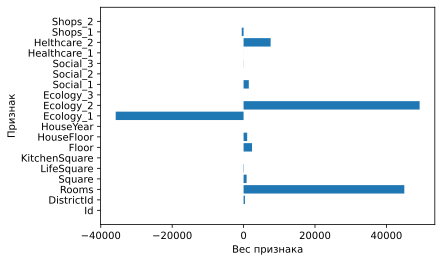

In [308]:
feature_names = X.columns

plt.barh(feature_names, lr_model.coef_.flatten())

plt.xlabel("Вес признака")
plt.ylabel("Признак")

plt.show()

**Стандартизация признаков:**

In [371]:
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_names)

X_valid_scaled = scaler.transform(X_valid)
X_valid_scaled = pd.DataFrame(X_valid_scaled, columns=feature_names)

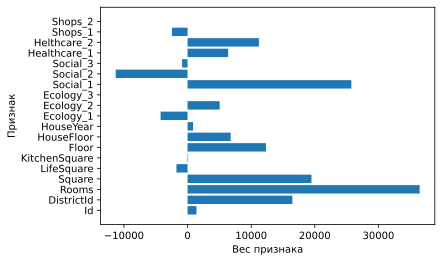

In [310]:
#Обучение  на стандартизованных признаках

lr_model.fit(X_train_scaled, y_train) 

plt.barh(feature_names, lr_model.coef_.flatten())

plt.xlabel("Вес признака")
plt.ylabel("Признак")

plt.show()

In [311]:
# Прогноз на стандартизированных признаках

lr_model.fit(X_train_scaled, y_train)
y_pred_st = lr_model.predict(X_valid_scaled)

In [312]:
r2_st = r2_score(y_valid, y_pred_st)
mse_st =  mean_squared_error(y_valid,y_pred_st)

In [313]:
RMSE = np.sqrt(mse)
RMSE_st = np.sqrt(mse_st)

In [314]:
print('R2 vs R2_st : {} vs {}'.format (r2.round(4),r2_st.round(4)))
print('MSE vs MSE_st : {} vs {}'.format (mse.round(4),mse_st.round(4)))
print('RMSE vs RMSE_st : {} vs {}'.format (RMSE.round(4),RMSE_st.round(4)))

R2 vs R2_st : 0.4637 vs 0.4637
MSE vs MSE_st : 4746499221.1115 vs 4746499221.1113
RMSE vs RMSE_st : 68894.8418 vs 68894.8418


In [315]:
w0_st = lr_model.intercept_ # w0
coef_st =lr_model.coef_

In [320]:
print('w0 vs w0_st : {} vs {}'.format (w0,w0_st))
print('coef\n{}'.format(coef))
print('coef_st\n{}'.format(coef_st))

w0 vs w0_st : -52693.93305249713 vs 212962.98771953126
coef
[ 2.86255850e-01  3.76858740e+02  4.50226874e+04  8.52693748e+02
 -9.27284727e+01  2.77318731e+00  2.36794482e+03  1.00667831e+03
  3.07484065e-03 -3.58140971e+04  4.93039660e+04  1.81898940e-11
  1.46274780e+03 -2.80228425e+00 -3.64041134e+01  8.52375632e+00
  7.57710640e+03 -5.13193296e+02  0.00000000e+00]
coef_st
[ 1.40006938e+03  1.64768394e+04  3.64709824e+04  1.94741787e+04
 -1.74821603e+03  7.82873917e+01  1.23178161e+04  6.77326735e+03
  8.71784437e+02 -4.23654180e+03  5.04917869e+03  6.36646291e-12
  2.57435968e+04 -1.12926281e+04 -8.57848193e+02  6.37546631e+03
  1.12114402e+04 -2.44029421e+03  0.00000000e+00]


In [375]:
max(np.abs(coef_st)) # Слишком выоские веса -признак переобучения

36470.982449570045

**Сложная модель(линейная регрессия с L1-регуляризацией)** <a class ='anchor' id ='Regularity_initial'>

В качестве сложной модели была выбрана модель дерева решений. 
В разделе будет проведено обучение модели на исходных тренировочных данных, а так же:
- Расчитана метрика R2 на двух наборах данных. 
- Сделаны итоговые выводы.
- Подберем оптимальные гиперпараметры для модели. 

In [392]:
alp = 0.03
lasso_model = Lasso(alpha = alp)

In [393]:
lasso_model.fit(X_train_scaled, y_train)
y_pred_lasso = lasso_model.predict(X_valid_scaled)

mse_lasso = mean_squared_error(y_valid,y_pred_lasso)
r2_lasso =r2_score(y_valid, y_pred_lasso)
RMSE_lasso =np.sqrt(mse_lasso)

In [394]:
print(f'alpha = {alp}')
print('R2_linear_st vs R2_lasso : {} vs {}'.format (r2_st.round(4),r2_lasso.round(4)))
print('MSE_linear_st vs MSE_lasso : {} vs {}'.format (mse_st.round(4), mse_lasso.round(4)))
print('RMSE_linear_st vs RMSE_lasso : {} vs {}'.format (RMSE_st.round(4), RMSE_lasso.round(4)))


alpha = 0.03
R2_linear_st vs R2_lasso : 0.4637 vs 0.4637
MSE_linear_st vs MSE_lasso : 4746499221.1113 vs 4746237901.2882
RMSE_linear_st vs RMSE_lasso : 68894.8418 vs 68892.9452
